<h1>Симуляция распространения инфекции в аэропортах США</h1>

**Подключение библиотек и загрузка данных**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import networkx as nx
from scipy.stats import spearmanr
from datetime import datetime
import pytz
import requests
import random
from tqdm import tqdm
from collections import defaultdict

In [2]:
data = pd.read_csv("data/2008.csv")

<h2>EDA</h2>

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       float64
 25  WeatherDelay      

Для нашей задачи нам понадобятся только **дата** и **время**, **аэропорты отправления** и **назначения**, **фактическое время отправления** и **прибытия**. Поэтому нас интересуют следующие столбцы:

<ol>
    <li>Year</li>
    <li>Month</li>
    <li>DayofMonth</li>
    <li>DepTime - запланированное время отправления (местное, ччмм, целое число)</li>
    <li>ArrTime - запланированное время прибытия (местное, ччмм, целое число)</li>
    <li>Origin - код аэропорта отправления</li>
    <li>Dest - код аэропорта назначения</li>
</ol>

In [4]:
target_columns = ["Year", "Month", "DayofMonth", "DepTime", "ArrTime", "Origin", "Dest"]

<h3>Поиск грязных данных</h3>

In [5]:
for column in data[["Year", "Month", "DayofMonth"]]:
    print(f"Список уникальных значений поля {column}: {data[column].unique()}")

Список уникальных значений поля Year: [2008]
Список уникальных значений поля Month: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Список уникальных значений поля DayofMonth: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31  2  1]


Временные значения находятся в допустимой доменной области. Однако, стоит проверить нет ли пропущенных значений в интересующих полях.

In [6]:
data[target_columns].isna().sum()

Year               0
Month              0
DayofMonth         0
DepTime       136246
ArrTime       151649
Origin             0
Dest               0
dtype: int64

<h3>Предобработка данных</h3>

*Заменим пропущенные значения* ***фактического времени отправки*** *и* ***прибытия*** *на* ***запланированное***

In [7]:
data.loc[data["DepTime"].isna(), "DepTime"] = data[data["DepTime"].isna()]["CRSDepTime"]
data.loc[data["ArrTime"].isna(), "ArrTime"] = data[data["ArrTime"].isna()]["CRSArrTime"]

data[["DepTime", "ArrTime"]].isna().sum()

DepTime    0
ArrTime    0
dtype: int64

Оставим только интересующие нас атрибуты

In [8]:
data = data[target_columns]

# У нас около 7 009 728 строк, поэтому оптимизируем хранение данных
data["Year"] = data["Year"].astype(np.int16)
data["Month"] = data["Month"].astype(np.int16)
data["DayofMonth"] = data["DayofMonth"].astype(np.int16)

# Для удобства создадим новые столбцы для вылета
data["DepYear"] = data["Year"]
data["DepMonth"] = data["Month"]
data["DepDayofMonth"] = data["DayofMonth"]

# И аналогичные столбцы для прилёта
data["ArrYear"] = data["Year"]
data["ArrMonth"] = data["Month"]
data["ArrDayofMonth"] = data["DayofMonth"]

data.drop(columns=["Year", "Month", "DayofMonth"], inplace=True)
data = data[["DepYear", "DepMonth", "DepDayofMonth", "DepTime", "Origin", 
                "ArrYear", "ArrMonth", "ArrDayofMonth", "ArrTime", "Dest"]]

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   DepYear        int16  
 1   DepMonth       int16  
 2   DepDayofMonth  int16  
 3   DepTime        float64
 4   Origin         object 
 5   ArrYear        int16  
 6   ArrMonth       int16  
 7   ArrDayofMonth  int16  
 8   ArrTime        float64
 9   Dest           object 
dtypes: float64(2), int16(6), object(2)
memory usage: 294.1+ MB


Объединим разрозненные столбцы времени в **единый datetime**

In [9]:
get_hours = lambda x: str(int(x // 100)).zfill(2)
get_minutes = lambda x: str(int(x % 100)).zfill(2)

data['DepHour'] = data['DepTime'].apply(get_hours)
data['DepMinute'] = data['DepTime'].apply(get_minutes)

data['ArrHour'] = data['ArrTime'].apply(get_hours)
data['ArrMinute'] = data['ArrTime'].apply(get_minutes)

data.drop(columns=["DepTime", "ArrTime"], inplace=True)

In [10]:
dep_mask = data['DepHour'] == 24
data.loc[dep_mask, 'DepHour'] = 0
data['DepDatetime'] = pd.to_datetime(dict(
    year=data['DepYear'],
    month=data['DepMonth'],
    day=data['DepDayofMonth'],
    hour=data['DepHour'],
    minute=data['DepMinute']
))
data.loc[dep_mask, 'DepDatetime'] += pd.Timedelta(days=1)

arr_mask = data['ArrHour'] == 24
data.loc[arr_mask, 'ArrHour'] = 0
data['ArrDatetime'] = pd.to_datetime(dict(
    year=data['ArrYear'],
    month=data['ArrMonth'],
    day=data['ArrDayofMonth'],
    hour=data['ArrHour'],
    minute=data['ArrMinute']
))
data.loc[arr_mask, 'ArrDatetime'] += pd.Timedelta(days=1)

In [11]:
data = data[["DepDatetime", "Origin", "ArrDatetime", "Dest"]]
data

,DepDatetime,Origin,ArrDatetime,Dest
0,2008-01-03 20:03:00,IAD,2008-01-03 22:11:00,TPA
1,2008-01-03 07:54:00,IAD,2008-01-03 10:02:00,TPA
2,2008-01-03 06:28:00,IND,2008-01-03 08:04:00,BWI
3,2008-01-03 09:26:00,IND,2008-01-03 10:54:00,BWI
4,2008-01-03 18:29:00,IND,2008-01-03 19:59:00,BWI
...,...,...,...,...
7009723,2008-12-13 10:02:00,ATL,2008-12-13 12:04:00,IAD
7009724,2008-12-13 08:34:00,ATL,2008-12-13 10:21:00,SAT
7009725,2008-12-13 06:55:00,PBI,2008-12-13 08:56:00,ATL
7009726,2008-12-13 12:51:00,IAD,2008-12-13 14:46:00,ATL


Сведем даты и времени к единому UTC, так как сейчас они указаны локально

In [12]:
response = requests.get("https://raw.githubusercontent.com/hroptatyr/dateutils/tzmaps/iata.tzmap")

In [13]:
if response.status_code == 200:
    content = response.text
    
    airports_utc_raw = content.split("\n")
    airports_utc_dep, airports_utc_arr = [], []

    for airport in airports_utc_raw[:-1]:
        airport_data = airport.split("\t")
        
        airports_utc_dep.append({"DepAirport": airport_data[0], 
                                 "DepLocation": airport_data[1]
                                })
        airports_utc_arr.append({"ArrAirport": airport_data[0], 
                                 "ArrLocation": airport_data[1],
                                })
        
    airports_utc_dep = pd.DataFrame(airports_utc_dep)
    airports_utc_arr = pd.DataFrame(airports_utc_arr)
else:
    print(f"Ошибка при загрузке: {response.status_code}")

In [14]:
merged_data = (data.merge(airports_utc_dep, left_on="Origin", right_on="DepAirport").
                merge(airports_utc_arr, left_on="Dest", right_on="ArrAirport"))

merged_data.drop(columns=["Origin", "Dest"], inplace=True)
full_data = merged_data[["DepDatetime", "DepAirport", "DepLocation", "ArrDatetime", "ArrAirport", "ArrLocation"]]
full_data

,DepDatetime,DepAirport,DepLocation,ArrDatetime,ArrAirport,ArrLocation
0,2008-01-03 20:03:00,IAD,America/New_York,2008-01-03 22:11:00,TPA,America/New_York
1,2008-01-03 07:54:00,IAD,America/New_York,2008-01-03 10:02:00,TPA,America/New_York
2,2008-01-04 20:02:00,IAD,America/New_York,2008-01-04 22:08:00,TPA,America/New_York
3,2008-01-04 07:34:00,IAD,America/New_York,2008-01-04 09:38:00,TPA,America/New_York
4,2008-01-05 20:00:00,IAD,America/New_York,2008-01-05 22:14:00,TPA,America/New_York
...,...,...,...,...,...,...
7009723,2008-12-27 10:10:00,SCC,America/Anchorage,2008-12-27 10:56:00,BRW,America/Anchorage
7009724,2008-12-28 10:09:00,SCC,America/Anchorage,2008-12-28 10:52:00,BRW,America/Anchorage
7009725,2008-12-29 09:46:00,SCC,America/Anchorage,2008-12-29 10:32:00,BRW,America/Anchorage
7009726,2008-12-30 09:46:00,SCC,America/Anchorage,2008-12-30 10:30:00,BRW,America/Anchorage


In [15]:
# Кэш для таймзон (значительно ускорит работу)
tz_cache = {}

def localize_tz(series, tz_series):
    results = []
    
    for dt, tz in tqdm(zip(series, tz_series), total=len(series), desc="Обработка таймзон"):
        if pd.isna(dt) or pd.isna(tz):  # Пропускаем NaN
            results.append(pd.NaT)
            continue

        if tz not in tz_cache:
            tz_cache[tz] = tz  # Кэшируем таймзоны

        results.append(dt.tz_localize(tz_cache[tz], ambiguous=False, 
                                      nonexistent='shift_forward').tz_convert('UTC'))

    return pd.Series(results, index=series.index)

full_data['DepLocation'] = full_data['DepLocation'].astype('category')
full_data['ArrLocation'] = full_data['ArrLocation'].astype('category')

full_data['DepUTC_Standardized'] = localize_tz(full_data['DepDatetime'], full_data['DepLocation'])
full_data['ArrUTC_Standardized'] = localize_tz(full_data['ArrDatetime'], full_data['ArrLocation'])

Обработка таймзон: 100%|██████████████████████████████████████████████████| 7009728/7009728 [06:05<00:00, 19183.30it/s]


In [16]:
full_data.sample(n=15, random_state=42)

,DepDatetime,DepAirport,DepLocation,ArrDatetime,ArrAirport,ArrLocation,DepUTC_Standardized,ArrUTC_Standardized
1767993,2008-04-08 21:45:00,ORD,America/Chicago,2008-04-08 23:55:00,DTW,America/Detroit,2008-04-09 02:45:00+00:00,2008-04-09 03:55:00+00:00
3073423,2008-10-03 19:36:00,LGA,America/New_York,2008-10-03 21:00:00,ORD,America/Chicago,2008-10-03 23:36:00+00:00,2008-10-04 02:00:00+00:00
922712,2008-12-22 16:37:00,PBI,America/New_York,2008-12-22 18:20:00,ATL,America/New_York,2008-12-22 21:37:00+00:00,2008-12-22 23:20:00+00:00
1517855,2008-03-08 21:50:00,DCA,America/New_York,2008-03-08 23:06:00,BOS,America/New_York,2008-03-09 02:50:00+00:00,2008-03-09 04:06:00+00:00
6480817,2008-01-19 13:15:00,SLC,America/Denver,2008-01-19 14:38:00,BZN,America/Denver,2008-01-19 20:15:00+00:00,2008-01-19 21:38:00+00:00
3622140,2008-05-21 16:03:00,DFW,America/Chicago,2008-05-21 17:17:00,SAN,America/Los_Angeles,2008-05-21 21:03:00+00:00,2008-05-22 00:17:00+00:00
5767083,2008-01-20 19:06:00,ATL,America/New_York,2008-01-20 20:56:00,IAD,America/New_York,2008-01-21 00:06:00+00:00,2008-01-21 01:56:00+00:00
3100375,2008-08-22 16:06:00,MSP,America/Chicago,2008-08-22 17:31:00,ORD,America/Chicago,2008-08-22 21:06:00+00:00,2008-08-22 22:31:00+00:00
4834716,2008-07-23 06:34:00,SNA,America/Los_Angeles,2008-07-23 12:00:00,DFW,America/Chicago,2008-07-23 13:34:00+00:00,2008-07-23 17:00:00+00:00
1602435,2008-10-28 14:54:00,PHX,America/Phoenix,2008-10-28 21:50:00,CLT,America/New_York,2008-10-28 21:54:00+00:00,2008-10-29 01:50:00+00:00


Разделим поля с местоположением на поле **Регион** и поле **Город**.<br>Удалим исходное локальное время и местоположение (с учетом региона и города).

In [17]:
def get_region(location):
    delimeter_reverse_idx = location[::-1].index("/")
    return location[:-delimeter_reverse_idx-1]


def get_city(location):
    delimeter_reverse_idx = location[::-1].index("/")
    return location[-delimeter_reverse_idx:]


full_data["DepRegion"] = full_data["DepLocation"].apply(get_region)
full_data["ArrRegion"] = full_data["ArrLocation"].apply(get_region)
full_data["DepCity"] = full_data["DepLocation"].apply(get_city)
full_data["ArrCity"] = full_data["ArrLocation"].apply(get_city)

full_data.drop(columns=["DepDatetime", "ArrDatetime", "DepLocation", "ArrLocation"], inplace=True)
full_data = full_data[["DepUTC_Standardized", "DepAirport", "DepRegion", "DepCity",
                       "ArrUTC_Standardized", "ArrAirport", "ArrRegion", "ArrCity"]]

<br>Создадим поле **Route** (Маршрут) для дальнейшего использования в ненаправленном графе. В нём будут храниться уникальные маршруты между аэропортами, независимо от направления (например, ('IAD', 'TPA') и ('TPA', 'IAD') будут одинаковыми).

In [18]:
full_data = full_data.copy()
full_data.loc[:, "Route"] = full_data.apply(lambda x: tuple(sorted([x["DepAirport"], x["ArrAirport"]])), axis=1)
full_data.sample(n=15, random_state=42)

,DepUTC_Standardized,DepAirport,DepRegion,DepCity,ArrUTC_Standardized,ArrAirport,ArrRegion,ArrCity,Route
1767993,2008-04-09 02:45:00+00:00,ORD,America,Chicago,2008-04-09 03:55:00+00:00,DTW,America,Detroit,"(DTW, ORD)"
3073423,2008-10-03 23:36:00+00:00,LGA,America,New_York,2008-10-04 02:00:00+00:00,ORD,America,Chicago,"(LGA, ORD)"
922712,2008-12-22 21:37:00+00:00,PBI,America,New_York,2008-12-22 23:20:00+00:00,ATL,America,New_York,"(ATL, PBI)"
1517855,2008-03-09 02:50:00+00:00,DCA,America,New_York,2008-03-09 04:06:00+00:00,BOS,America,New_York,"(BOS, DCA)"
6480817,2008-01-19 20:15:00+00:00,SLC,America,Denver,2008-01-19 21:38:00+00:00,BZN,America,Denver,"(BZN, SLC)"
3622140,2008-05-21 21:03:00+00:00,DFW,America,Chicago,2008-05-22 00:17:00+00:00,SAN,America,Los_Angeles,"(DFW, SAN)"
5767083,2008-01-21 00:06:00+00:00,ATL,America,New_York,2008-01-21 01:56:00+00:00,IAD,America,New_York,"(ATL, IAD)"
3100375,2008-08-22 21:06:00+00:00,MSP,America,Chicago,2008-08-22 22:31:00+00:00,ORD,America,Chicago,"(MSP, ORD)"
4834716,2008-07-23 13:34:00+00:00,SNA,America,Los_Angeles,2008-07-23 17:00:00+00:00,DFW,America,Chicago,"(DFW, SNA)"
1602435,2008-10-28 21:54:00+00:00,PHX,America,Phoenix,2008-10-29 01:50:00+00:00,CLT,America,New_York,"(CLT, PHX)"


Наш датасет готов для использования в симуляции распространения болезни через авиарейсы.<br><br>*Объединим аэропорты вылета и прибытия для дальнейшего использования в процессе выполнения симуляций*

In [19]:
airport_city_data = pd.concat([
    full_data[["DepAirport", "DepCity"]].rename(columns={"DepAirport": "Airport", "DepCity": "City"}), 
    full_data[["ArrAirport", "ArrCity"]].rename(columns={"ArrAirport": "Airport", "ArrCity": "City"})
], ignore_index=True).drop_duplicates()

<h2>Симуляция распространения инфекции</h2>

<h3>Функция, описывающая распространение инфекции</h3>
Функция должна принимать на вход стартовый аэропорт, в котором изначально началась инфекция и вероятность распространения инфекции p. На выходе функция должна возвращать словарь, в котором ключом будет время заражения аэропорта, значением - название аэропорта.

In [20]:
def simulate_airport_epidemic(start_airport: str, 
                              start_time: datetime = datetime(2008, 1, 1), 
                              p: float = 0.5) -> dict:
    '''
    Симуляция распространения инфекции через авиарейсы.

    :param start_airport: Название аэропорта, с которого начинается заражение.
    :param start_time: Дата начала симуляции (рейсы до этой даты не учитываются).
    :param p: Вероятность распространения инфекции (по умолчанию 0.5).
    :return: Словарь {время заражения: список аэропортов}.
    '''
    
    # Фильтр рейсов: оставляем только те, которые вылетели не ранее `start_date`
    if start_time.tzinfo is None:
        start_time = start_time.replace(tzinfo=pytz.UTC)
        
    # Отсортированные по времени отправления перелёты
    sorted_flights = full_data.loc[
        full_data["DepUTC_Standardized"] > start_time
    ].sort_values("DepUTC_Standardized", ignore_index=True)
    
    # Словарь аэропортов и времени их заражения
    infected = {start_airport: start_time}

    # Процесс итеративного заражения аэропортов с заданной вероятностью
    for flight in sorted_flights.itertuples(index=False):            
        dep_time = flight.DepUTC_Standardized.to_pydatetime()
        arr_time = flight.ArrUTC_Standardized.to_pydatetime()
        
        # Аэропорт отправления должен быть заражен, и заражение должно произойти до отправления рейса
        if (flight.DepAirport in infected and flight.ArrAirport not in infected and 
            infected[flight.DepAirport] < dep_time and random.random() <= p):
                infected[flight.ArrAirport] = arr_time

    statistics = defaultdict(list)
    for airport, date_time in sorted(infected.items(), key=lambda x: x[1]):
        statistics[date_time].append(airport)
                             
    return statistics

Первый запуск симуляции

In [21]:
START_AIRPORT = "SAN"

np.random.seed(42)
first_simulation = simulate_airport_epidemic(START_AIRPORT, p=0.75)

# Количество уникальных временных меток заражения
num_unique_dates = len(first_simulation)

# Количество зараженных аэропортов в каждый момент времени
infected_airport_by_time = [len(airports) for airports in first_simulation.values()]

print(f"Количество уникальных временных меток заражения: {num_unique_dates}")
print(
    f"Количество зараженных аэропортов: {sum(infected_airport_by_time)} из "
    f"{airport_city_data['Airport'].nunique()}"
)
print(f"Максимально заражено аэропортов в один момент: {max(infected_airport_by_time, default=0)}")

Количество уникальных временных меток заражения: 256
Количество зараженных аэропортов: 304 из 305
Максимально заражено аэропортов в один момент: 4


<h3>Оценка влияния вероятности заражения болезнью на скорость распространения</h3>

In [22]:
test_probabilities=[0.01, 0.05, 0.1, 0.5, 1]
simulations_quantity_per_p = 10
results = defaultdict(list)

for i, probability in enumerate(test_probabilities):
    for _ in range(simulations_quantity_per_p):
        np.random.seed(int(random.uniform(0, 1000)))
        results[probability].append(simulate_airport_epidemic(START_AIRPORT, p=probability))

In [23]:
def analyze_infection_speed(results, airport_city_data):
    """
    Вычисляет средний процент зараженных аэропортов во времени.

    :param results: Словарь {p: [список симуляций]}, где p - вероятность заражения.
    :param airport_city_data: DataFrame с аэропортами и городами.
    :return: Словарь infection_analysis_airports {p: Series}, где Series - процент зараженных аэропортов 
    во времени.
    """
    
    infection_analysis_airports = {}  # Процент зараженных аэропортов
    
    for probability, simulations in results.items():
        infection_data_airports = []

        for simulation in simulations:
            # Создаем DataFrame зараженных аэропортов {время: [список зараженных аэропортов]}
            df = pd.DataFrame([(time, len(airports)) for time, airports in simulation.items()], 
                              columns=["time", "infected_airports"])
            
            df["time"] = pd.to_datetime(df["time"])
            df = df.sort_values("time").reset_index(drop=True)
            
            # Накопительное число зараженных аэропортов
            df["cumulative_infected_airports"] = df["infected_airports"].cumsum()
            infection_data_airports.append(df)

        # Объединение всех симуляций по аэропортам
        all_simulations_airports = pd.concat(infection_data_airports)
        all_simulations_airports["time_bin"] = all_simulations_airports["time"].dt.floor("12H")
        
        avg_infection_airports = (
            all_simulations_airports
            .groupby("time_bin")["cumulative_infected_airports"]
            .mean()
        )
        
        avg_infection_airports_percentage = (
            avg_infection_airports / airport_city_data["Airport"].nunique()
        ) * 100
        
        infection_analysis_airports[probability] = avg_infection_airports_percentage
    
    return infection_analysis_airports

In [24]:
infection_analysis_airports = analyze_infection_speed(
    results=results,
    airport_city_data=airport_city_data
)

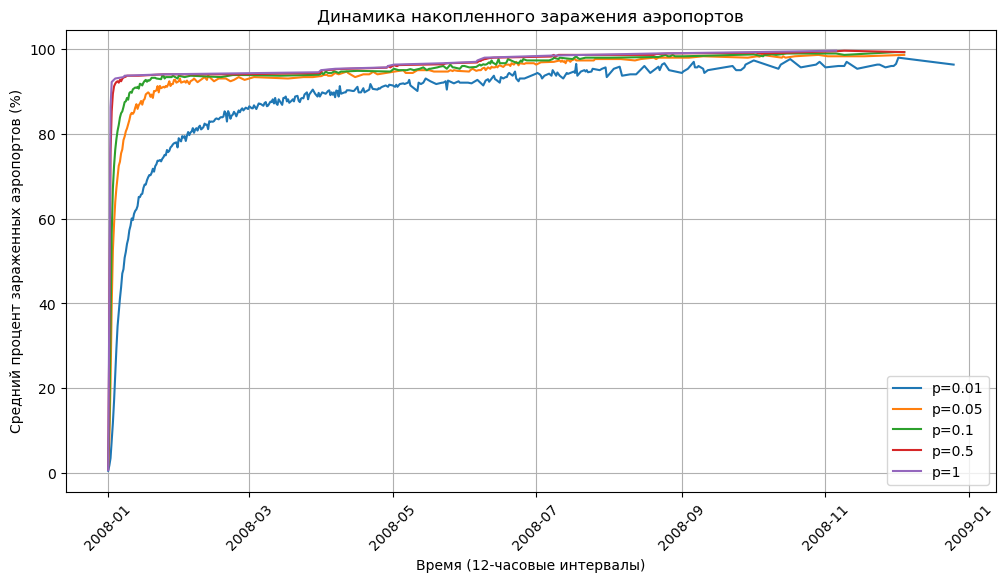

In [25]:
plt.figure(figsize=(12, 6))

for probability, infection_series in infection_analysis_airports.items():
    plt.plot(infection_series.index, infection_series.values, label=f"p={probability}")

plt.xlabel("Время (12-часовые интервалы)")
plt.ylabel("Средний процент зараженных аэропортов (%)")
plt.title("Динамика накопленного заражения аэропортов")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

Так как инфекция распространяется стремительно, визуализируем динамику заражения в течение первого месяца.

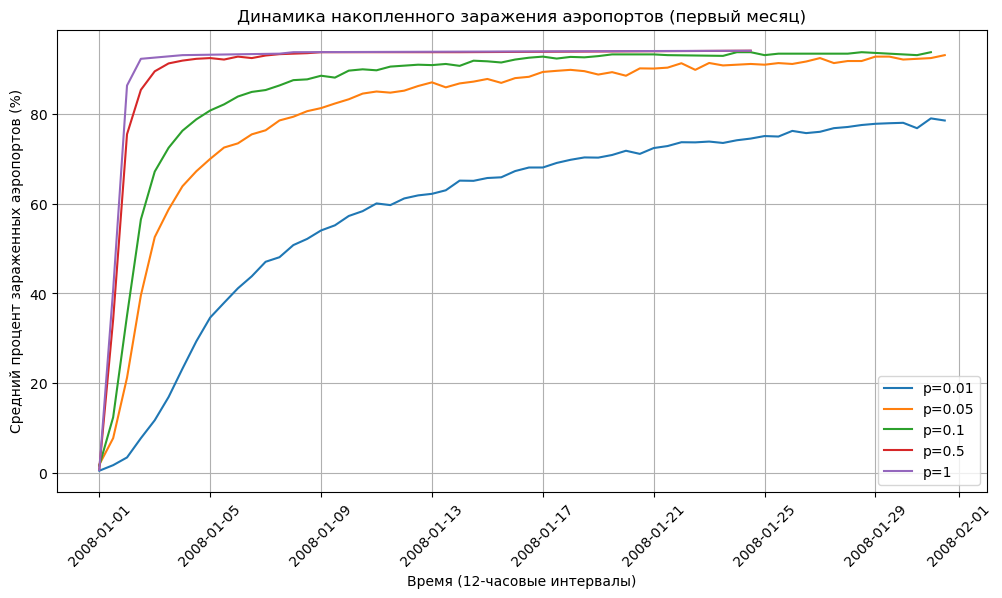

In [26]:
# Определяем начало данных во всех сериях
start_time = min(series.index.min() for series in infection_analysis_airports.values())  
end_time = start_time + pd.DateOffset(months=1)

plt.figure(figsize=(12, 6))

for probability, infection_series in infection_analysis_airports.items():
    # Фильтруем только первый месяц
    filtered_series = infection_series.loc[(infection_series.index >= start_time) & 
                                           (infection_series.index < end_time)]
    
    plt.plot(filtered_series.index, filtered_series.values, label=f"p={probability}")

plt.xlabel("Время (12-часовые интервалы)")
plt.ylabel("Средний процент зараженных аэропортов (%)")
plt.title("Динамика накопленного заражения аэропортов (первый месяц)")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

На графике, отображающем **средний процент зараженных аэропортов на временной шкале**, можно наблюдать **скачкообразный** характер кривой. Это объясняется тем, что **усреднение объединяет разные сценарии распространения инфекции**. В каждой симуляции инфекция могла распространяться с разной скоростью, что приводит к небольшим колебаниям на графике.<br /><br />
Такое усреднение по нескольким симуляциям позволяет нам получить **более обобщенное и надежное** представление о процессе распространения инфекции.

**Выводы:**

1. **Инфекция распространяется очень быстро, даже при низких значениях вероятности (p)**
   - Почти все аэропорты заражаются в течение первых нескольких временных интервалов.
   - Даже при p=0.01 (самая низкая вероятность) заражение достигает практически 100% в течение года.


2. **Чем выше вероятность p, тем быстрее достигается насыщение (100% зараженных аэропортов)**
   - При p=1.0 заражение происходит почти мгновенно — все аэропорты заражены уже в самом начале.
   - При p=0.05 и выше заражение достигает практически 100% в течение первого полугода.
   - При p=0.01 процесс идет медленнее, но тоже достигает насыщения.


3. **Нет значительной разницы между p=0.5 и p=1.0**
   - Графики для p=0.5 и p=1.0 практически идентичны.
   - Это говорит о том, что при p ≥ 0.5 инфекция распространяется почти мгновенно.
   - Вероятно, существует "критическая вероятность", выше которой дальнейшее увеличение p не ускоряет заражение.


4. **Заражение имеет экспоненциальный характер**
   - В начале график растет очень быстро (почти вертикально).
   - Затем замедляется, приближаясь к 100% (кривая выходит на плато).

<h3>Применение графов для предсказания распространения инфекции</h3>

<h4>Формирование графа маршрутов авиарейсов</h4>

In [27]:
graph = nx.Graph()

# Всего рейсов
total_flights = full_data.shape[0]

# Группируем данные по одинаковым маршрутам
flights_counts = full_data.groupby("Route").size()

# Формируем граф
for (airport1, airport2), flights_count in flights_counts.items():
    graph.add_node(airport1, city=airport_city_data.loc[airport_city_data["Airport"] == airport1, "City"].iloc[0])
    graph.add_node(airport2, city=airport_city_data.loc[airport_city_data["Airport"] == airport2, "City"].iloc[0])
    graph.add_edge(airport1, airport2, weight=flights_count / total_flights)

In [28]:
edges_list = list(graph.edges(data=True))
first_5_edges = edges_list[:5]
last_5_edges = edges_list[-5:]
        
print("Всего рейсов:", total_flights)
print("Узлов:", len(graph.nodes))
print("Рёбер:", len(graph.edges(data=True)))
print()
print("Первые 5 ребер:", *first_5_edges, sep="\n")
print()
print("Последние 5 ребер:", *last_5_edges, sep="\n")

Всего рейсов: 7009728
Узлов: 305
Рёбер: 2834

Первые 5 ребер:
('ABE', 'ATL', {'weight': 0.00024323340363563323})
('ABE', 'BHM', {'weight': 1.4265888776283474e-07})
('ABE', 'CLE', {'weight': 0.00022968080929816392})
('ABE', 'CLT', {'weight': 0.0001326727656194363})
('ABE', 'CVG', {'weight': 7.061614944260319e-05})

Последние 5 ребер:
('SBA', 'SBP', {'weight': 1.4265888776283474e-07})
('YUM', 'IPL', {'weight': 9.543879591333643e-05})
('KTN', 'SIT', {'weight': 0.00010414098806686936})
('KTN', 'WRG', {'weight': 0.00010371301140358085})
('PSG', 'WRG', {'weight': 0.00010371301140358085})


<h4>Визуализация графа маршрутов авиарейсов</h4>

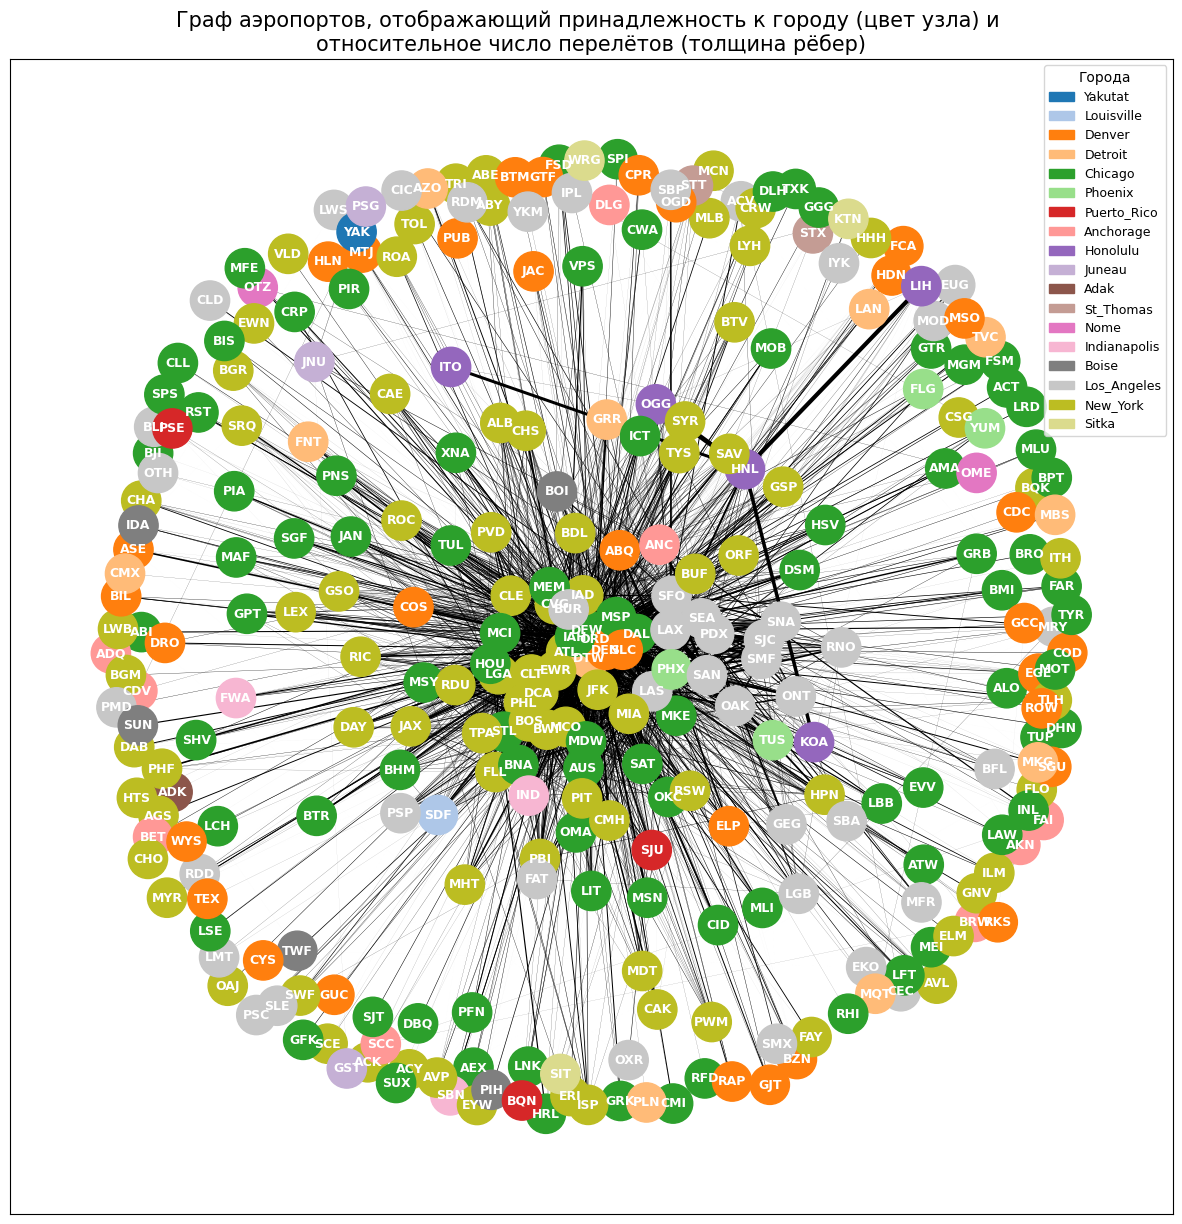

In [29]:
# Определяем цвета для городов
unique_cities = set(airport_city_data["City"].values)
city_colors = {city: plt.cm.get_cmap("tab20")(i % 20) for i, city in enumerate(unique_cities)}

# Генерируем цвета рёбер и их толщину
edge_weights = []

for u, v, data in graph.edges(data=True):
    edge_weights.append(data["weight"] * 1000)  # Масштабируем для визуализации

# Визуализация графа
fig, ax = plt.subplots(figsize=(15, 15))

# Позиционирование узлов (Spring layout)
pos = nx.spring_layout(graph, seed=42)

# Рисуем узлы (города) с цветами по городам
node_colors = [city_colors.get(graph.nodes[node].get("city", "Unknown"), "lightgray") for node in graph.nodes]
nx.draw_networkx_nodes(graph, pos, node_size=800, node_color=node_colors, ax=ax)

# Рисуем рёбра с разными толщинами
nx.draw_networkx_edges(graph, pos, width=edge_weights, ax=ax)

# Подписываем узлы (аэропорты)
nx.draw_networkx_labels(graph, pos, font_size=9, font_weight="bold", font_color="white", ax=ax)

# Создаём легенду с цветами городов
legend_patches = [mpatches.Patch(color=color, label=city) for city, color in city_colors.items()]
ax.legend(handles=legend_patches, title="Города", loc="upper right", fontsize=9, title_fontsize=10)

plt.title("Граф аэропортов, отображающий принадлежность к городу (цвет узла) и \n" 
          "относительное число перелётов (толщина рёбер)", 
          fontsize=15)
plt.show()

<h4>Расчёт метрик графа</h4>

- **Коэффициент кластеризации (`nx.clustering`)**  
  - Показывает, насколько связаны между собой соседи аэропорта.  
  - Высокое значение указывает на плотную локальную сеть, низкое — на изолированный узел.  


- **Степень узла (`nx.degree`)**  
  - Определяет количество маршрутов аэропорта с другими.  
  - Чем выше степень, тем больше рейсов проходит через аэропорт.  


- **Центральность посредничества (`nx.betweenness_centrality`)**  
  - Показывает, насколько аэропорт критичен для маршрутов.  
  - Высокое значение означает, что через этот аэропорт проходит много кратчайших путей.  
  - Ключевые транзитные узлы имеют высокий показатель.  


In [30]:
clustering = nx.clustering(graph, weight="weight")
degree = dict(graph.degree(weight="weight"))
centrality = nx.betweenness_centrality(graph, weight="weight")
              
node_metrics = pd.DataFrame.from_dict(clustering , orient="index", columns=["clustering"]).join([
    pd.DataFrame.from_dict(degree ,orient="index", columns=["degree"]),
    pd.DataFrame.from_dict(centrality ,orient="index", columns=["centrality"])
])

In [31]:
node_metrics.sort_values("clustering", ascending=False).loc[:, ["clustering"]].head()

,clustering
LFT,0.178200
LAW,0.157279
ITO,0.141637
GRK,0.139439
LSE,0.137243


In [32]:
node_metrics.sort_values("degree", ascending=False).loc[:, ["degree"]].head()

,degree
ATL,0.118269
ORD,0.099980
DFW,0.080272
DEN,0.068892
LAX,0.061528


In [33]:
node_metrics.sort_values("centrality", ascending=False).loc[:, ["centrality"]].head()

,centrality
BOI,0.208582
GJT,0.208454
TWF,0.191048
GRB,0.165124
ORD,0.159776


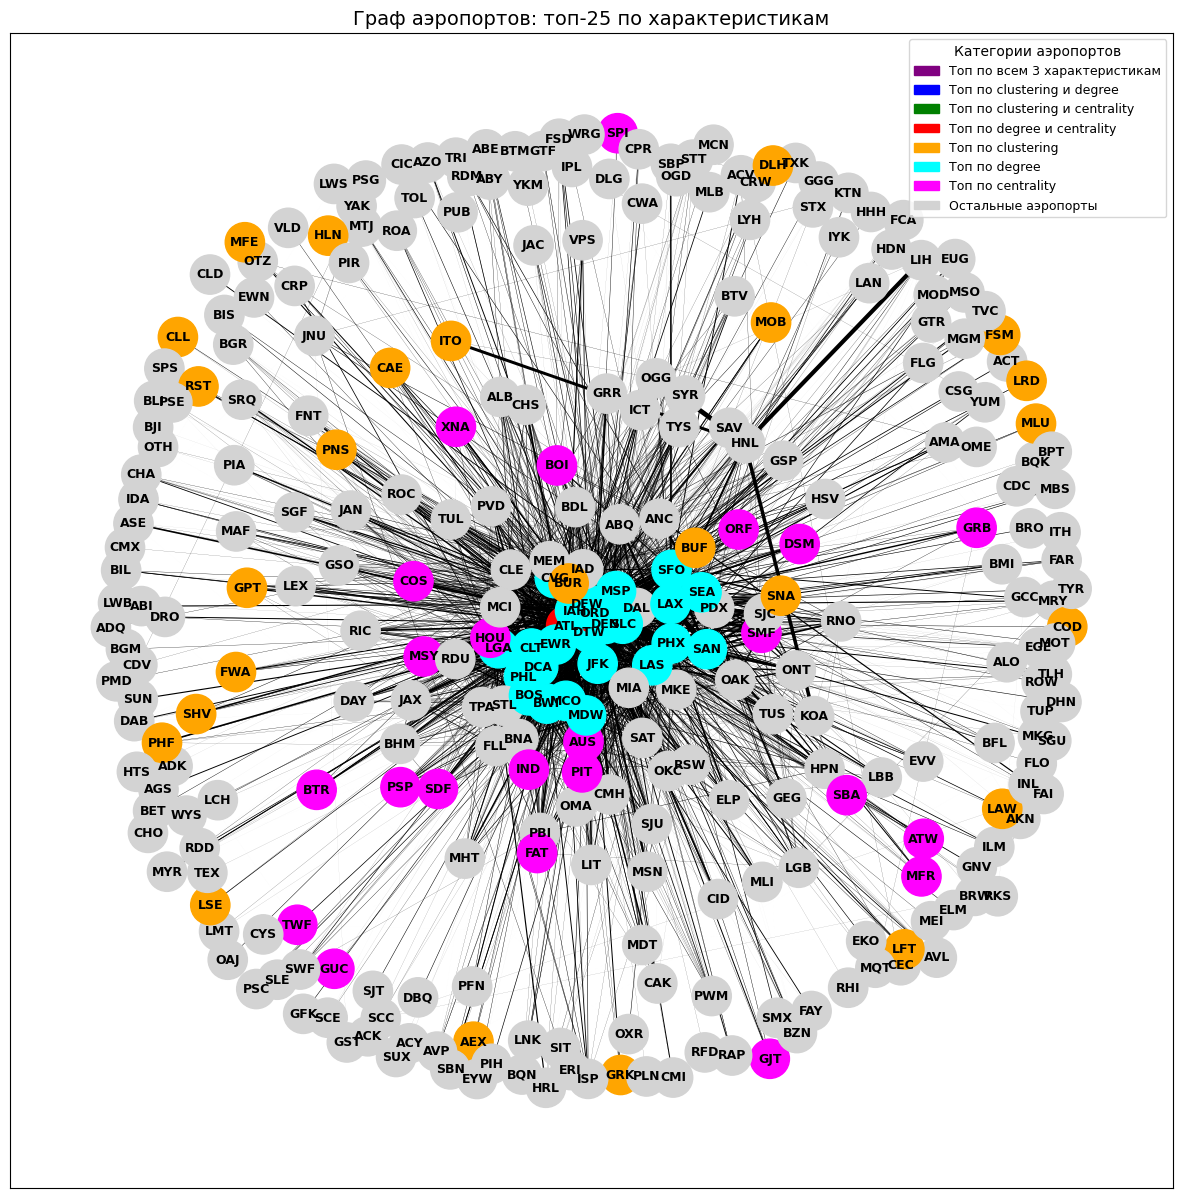

In [34]:
# Определяем топ-25 аэропортов по характеристикам
TOP_QUANTITY = 25

top_clustering = node_metrics.nlargest(TOP_QUANTITY, "clustering").index
top_degree = node_metrics.nlargest(TOP_QUANTITY, "degree").index
top_centrality = node_metrics.nlargest(TOP_QUANTITY, "centrality").index

# Создаём цветовую схему для аэропортов
node_colors = {}
for node in graph.nodes():
    if node in top_clustering and node in top_degree and node in top_centrality:
        node_colors[node] = "purple"  # Топ по всем 3 характеристикам
    elif node in top_clustering and node in top_degree:
        node_colors[node] = "blue"
    elif node in top_clustering and node in top_centrality:
        node_colors[node] = "green"
    elif node in top_degree and node in top_centrality:
        node_colors[node] = "red"
    elif node in top_clustering:
        node_colors[node] = "orange"
    elif node in top_degree:
        node_colors[node] = "cyan"
    elif node in top_centrality:
        node_colors[node] = "magenta"
    else:
        node_colors[node] = "lightgray"  # Остальные аэропорты

# Генерируем толщину рёбер
edge_weights = [data["weight"] * 1000 for _, _, data in graph.edges(data=True)]

# Визуализация графа
fig, ax = plt.subplots(figsize=(15, 15))

# Позиционирование узлов
pos = nx.spring_layout(graph, seed=42)

# Рисуем узлы с цветами по топ-25 характеристикам
nx.draw_networkx_nodes(graph, pos, node_size=800, node_color=[node_colors[node] for node in graph.nodes()], ax=ax)

# Рисуем рёбра с разными толщинами
nx.draw_networkx_edges(graph, pos, width=edge_weights, ax=ax)

# Подписываем узлы (аэропорты)
nx.draw_networkx_labels(graph, pos, font_size=9, font_weight="bold", ax=ax)

# Создаём легенду
legend_patches = [
    mpatches.Patch(color="purple", label="Топ по всем 3 характеристикам"),
    mpatches.Patch(color="blue", label="Топ по clustering и degree"),
    mpatches.Patch(color="green", label="Топ по clustering и centrality"),
    mpatches.Patch(color="red", label="Топ по degree и centrality"),
    mpatches.Patch(color="orange", label="Топ по clustering"),
    mpatches.Patch(color="cyan", label="Топ по degree"),
    mpatches.Patch(color="magenta", label="Топ по centrality"),
    mpatches.Patch(color="lightgray", label="Остальные аэропорты"),
]
ax.legend(handles=legend_patches, title="Категории аэропортов", loc="upper right", fontsize=9, title_fontsize=10)

plt.title(f"Граф аэропортов: топ-{TOP_QUANTITY} по характеристикам", fontsize=14)
plt.show()

Аэропорт **ATL** — **единственный** (исходя из визуализации графа) среди ТОП-25, <br>который входит в рейтинг по **двум мерам центральности**: степени и посредничеству:

In [35]:
# Общее количество рейсов, в которых участвовал ATL (как отправной или прибытия)
ATL_flights = full_data.loc[(full_data["DepAirport"] == "ATL") | (full_data["ArrAirport"] == "ATL")].shape[0]

# Вычисление процента рейсов с участием ATL
ATL_flights_percentage = 100 * ATL_flights / total_flights

# Получаем список уникальных аэропортов, с которыми ATL взаимодействовал
ATL_connections = set(full_data.loc[full_data["DepAirport"] == "ATL", "ArrAirport"]).union(
                  set(full_data.loc[full_data["ArrAirport"] == "ATL", "DepAirport"]))

# Вычисление процента уникальных аэропортов, с которыми ATL взаимодействовал
ATL_connections_percentage = 100 * len(ATL_connections) / airport_city_data["Airport"].nunique()

# Вывод результатов
print(f"Всего рейсов, в которых принимал участие аэропорт ATL: {ATL_flights}, "
      f"что составляет {ATL_flights_percentage:.2f}% от общего числа рейсов.")
print(f"Аэропорт ATL взаимодействовал с {len(ATL_connections)} уникальными аэропортами, "
      f"что составляет {ATL_connections_percentage:.2f}% от общего числа аэропортов.")

Всего рейсов, в которых принимал участие аэропорт ATL: 829034, что составляет 11.83% от общего числа рейсов.
Аэропорт ATL взаимодействовал с 173 уникальными аэропортами, что составляет 56.72% от общего числа аэропортов.


Сравнительный анализ коэффициентов кластеризации, степени и центральности, <br>с **медианным временем заражения** (вычисленным на основе пятидесятикратной симуляции)

In [36]:
# Запуск симуляции 50 раз и сохранение результатов
num_simulations = 50

simulation_results = []
for _ in range(num_simulations):
    result = simulate_airport_epidemic(start_airport=START_AIRPORT)
    simulation_results.append(result)

# Словарь для хранения времени заражения каждого аэропорта
infection_times = defaultdict(list)

for sim in simulation_results:
    for time, airports in sim.items():
        for airport in airports:
            infection_times[airport].append(time)

            
# Вычислим медианное время заражения для каждого аэропорта
median_infection_times = {
    airport: pd.to_datetime(sorted(times)).to_series().quantile(0.5)
    for airport, times in infection_times.items()
}

df_median_infections = pd.DataFrame(
    median_infection_times.items(), columns=["Airport", "Median Infection Time"]
).sort_values("Median Infection Time")


df_median_infections = df_median_infections.set_index("Airport")
df_median_infections

,Median Infection Time
Airport,
SAN,2008-01-01 00:00:00+00:00
BQN,2008-01-01 07:33:00+00:00
PSE,2008-01-01 08:51:00+00:00
LAX,2008-01-01 14:59:00+00:00
SLC,2008-01-01 16:05:00+00:00
...,...
OTH,2008-07-07 20:25:00+00:00
LMT,2008-07-08 06:35:00+00:00
ITH,2008-08-20 15:10:00+00:00


In [37]:
# Объединим таблицы
df_combined = node_metrics.join(df_median_infections)

# Преобразуем столбец в datetime и удалим информацию о часовом поясе
df_combined["Median Infection Time"] = pd.to_datetime(df_combined["Median Infection Time"], 
                                                      errors='coerce').dt.tz_localize(None)

# Вычислим время заражения относительно начала эпидемии (в часах и днях)
df_combined["Median Infection Time (hours)"] = (df_combined["Median Infection Time"] - 
                                                datetime(2008, 1, 1)).dt.total_seconds() / 3600
df_combined["Median Infection Time (days)"] = df_combined["Median Infection Time (hours)"] / 24

# Обработаем случаи, когда узел не заразился
max_days = df_combined["Median Infection Time (days)"].max()
buffer_days = max_days * 1.25  # Добавляем 25% сверху, чтобы отделить незаражённые узлы

df_combined["Median Infection Time (days)"].fillna(buffer_days, inplace=True)
df_combined["Median Infection Time (hours)"].fillna(buffer_days * 24, inplace=True)

df_combined

,clustering,degree,centrality,Median Infection Time,Median Infection Time (hours),Median Infection Time (days)
ABE,0.025966,0.001370,0.001032,2008-01-01 22:50:00,22.833333,0.951389
ATL,0.022777,0.118269,0.127454,2008-01-01 19:56:00,19.933333,0.830556
BHM,0.042371,0.006756,0.020993,2008-01-01 20:17:00,20.283333,0.845139
CLE,0.033988,0.018772,0.000000,2008-01-01 20:18:00,20.300000,0.845833
CLT,0.042964,0.035961,0.044871,2008-01-01 20:21:00,20.350000,0.847917
...,...,...,...,...,...,...
TEX,0.000000,0.000055,0.000000,2008-01-01 19:46:00,19.766667,0.823611
SLE,0.007017,0.000138,0.000000,2008-01-02 06:06:00,30.100000,1.254167
SUN,0.014566,0.000824,0.000000,2008-01-01 19:28:00,19.466667,0.811111
WYS,0.000000,0.000075,0.000000,2008-06-07 15:43:00,3807.716667,158.654861


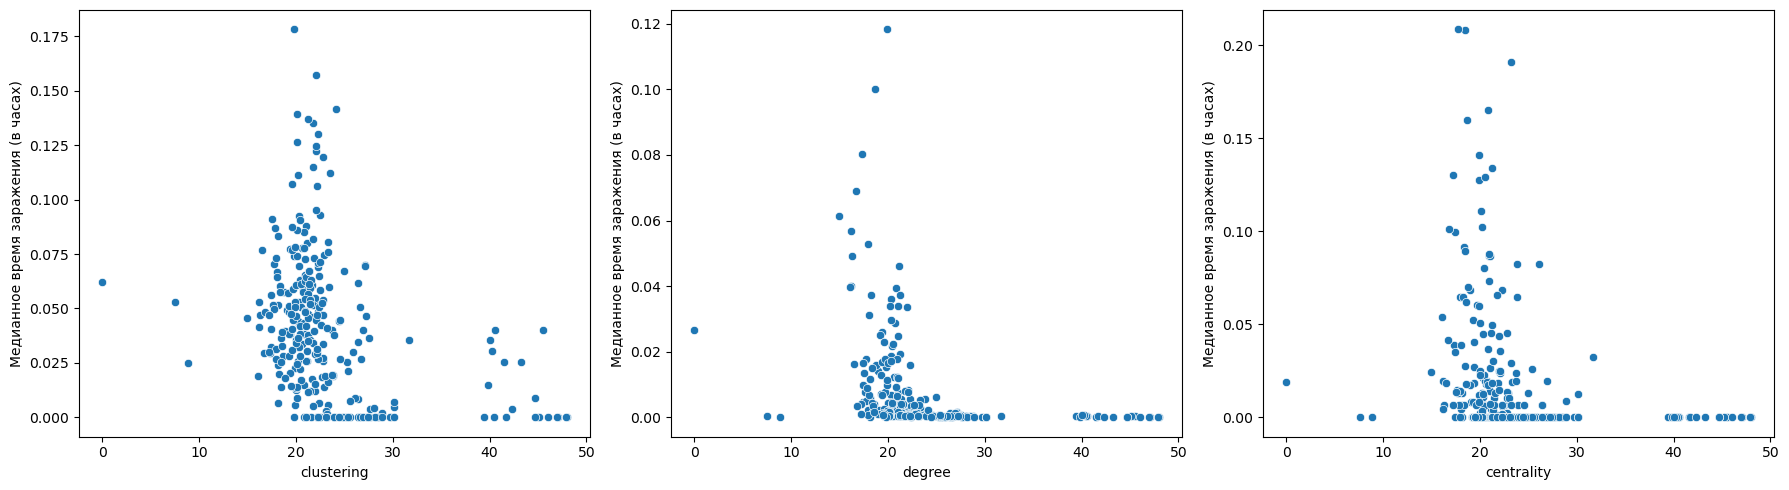

In [38]:
# Отфильтруем данные: оставим только аэропорты, заразившиеся в первые 48 часов
df_filtered = df_combined[df_combined["Median Infection Time (hours)"] <= 48]

# Визуализация scatter-плотов для первых 48 часов
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ["clustering", "degree", "centrality"]
titles = ["Коэффициент кластеризации", "Степень вершины", "Центральность посредничества"]

for i, metric in enumerate(metrics):
    sns.scatterplot(x=df_filtered["Median Infection Time (hours)"], y=df_filtered[metric], ax=axes[i])
    axes[i].set_xlabel(metric)
    axes[i].set_ylabel("Медианное время заражения (в часах)")

plt.tight_layout()
plt.show()

In [39]:
metrics = ["clustering", "degree", "centrality"]
correlations = {}

for metric in metrics:
    corr, p_value= spearmanr(df_combined[metric], df_combined["Median Infection Time (hours)"])
    correlations[metric] = {"Spearman Correlation": corr, "p-value": p_value}

df_correlations = pd.DataFrame.from_dict(correlations, orient="index")
df_correlations

,Spearman Correlation,p-value
clustering,-0.473904,1.757285e-18
degree,-0.718937,8.680538e-50
centrality,-0.451113,1.072957e-16


<h4>Интерпретация результатов корреляции Спирмена</h4>

Все p-value оказались **очень маленькими**, что означает, что результаты **статистически значимы**. <br>Вероятность случайности корреляций практически нулевая. Мы можем доверять этим результатам.


#### Интерпретация:

1. **Degree (-0.71, p ≈ 0)**
   - **Сильная отрицательная корреляция**:  
     → Узлы с большим числом связей заражаются **раньше**.  
     → Чем больше связей, тем выше вероятность заразиться.


2. **Clustering (-0.45, p ≈ 0)**  
   - **Средняя отрицательная корреляция**:  
     → Узлы, окружённые плотной группой соседей, заражаются **раньше**.  
     → Это логично, так как инфекция быстрее распространяется в кластерах.


3. **Centrality (-0.46, p ≈ 0)**  
   - **Средняя отрицательная корреляция**:  
     → Центральные узлы заражаются **раньше**, так как они связаны со многими другими.


<h2>Вывод:</h2>

- Количество связей/рейсов (`degree`) — **главный фактор быстрого заражения**.
- Центральность (`centrality`) и кластеризация (`clustering`) **тоже важны**, но их **влияние слабее**.
- p-value очень низкие, значит, результаты **надежные**.
- **Все коэффициенты отрицательные** → чем выше метрика, тем раньше узел заражается.